In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from keras.callbacks import LearningRateScheduler, CSVLogger , ReduceLROnPlateau

In [2]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
initializer = initializers.RandomUniform(minval=-1.0, maxval=1.0)

class regressor(Model):
    def __init__(self):
        super(regressor, self).__init__()
        self.reg = tf.keras.Sequential([
            layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
            layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
            layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=initializer),
            layers.Dense(1, activation='sigmoid',kernel_initializer=initializer)
        ])

    def call(self, x):
        y = self.reg(x)
        return y

In [4]:
dataset = pd.read_csv('encoded_dataset.csv',usecols=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','heat_of_formation'])
dataset.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,heat_of_formation
0,-3.322135,-1.244621,13.524710,-0.909419,-0.319857,-0.401867,-0.460063,-0.547173,-1.324745,-0.223110,-1.240558
1,-2.013694,-0.375983,-0.368822,-0.753132,0.095981,-0.177919,-0.138669,0.233631,-0.397156,-0.902226,-1.012833
2,-1.874180,-0.371672,-0.136253,-1.587671,0.412010,-0.136558,-0.118256,1.158614,-0.325826,-0.843122,-1.145090
3,-3.290193,-1.220618,13.068223,-0.986928,-0.299022,-0.390303,-0.443385,-0.506335,-1.298785,-0.258119,-1.112540
4,-3.119336,-1.178411,13.246580,-1.510718,-0.248259,-0.355021,-0.415747,-0.369363,-1.206637,-0.228235,-1.162859


In [5]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [6]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
ms = MinMaxScaler(feature_range=(0,1))
y_scaled = ms.fit_transform(y.reshape(540,-1))

In [7]:
def scheduler(epoch, lr):
    if epoch<25:
        return lr
    elif epoch >=25 and epoch < 50:
        return lr*0.99
    elif epoch >=50 and epoch <75:
        return lr*0.98
    else:
        return lr*0.80


In [8]:
lr_scheduler = LearningRateScheduler(
    scheduler,
    verbose=1
)

In [9]:
log_csv = CSVLogger(
    'model_logs.csv',
    separator = ',',
    append=False
)

In [10]:
rlr = ReduceLROnPlateau(
    monitor='loss',
    patience=3,
    factor=0.85
)

In [11]:
model = regressor()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.02), loss='mean_squared_error')

In [12]:
model.fit(X_scaled, y_scaled, epochs=100, batch_size=5, shuffle=True, callbacks=[log_csv,rlr,lr_scheduler])


Epoch 00001: LearningRateScheduler setting learning rate to 0.019999999552965164.
Epoch 1/100
108/108 [==============================] - 1s 2ms/step - loss: 0.1611 - lr: 0.0200

Epoch 00002: LearningRateScheduler setting learning rate to 0.019999999552965164.
Epoch 2/100
108/108 [==============================] - 0s 2ms/step - loss: 0.1320 - lr: 0.0200

Epoch 00003: LearningRateScheduler setting learning rate to 0.019999999552965164.
Epoch 3/100
108/108 [==============================] - 0s 2ms/step - loss: 0.1008 - lr: 0.0200

Epoch 00004: LearningRateScheduler setting learning rate to 0.019999999552965164.
Epoch 4/100
108/108 [==============================] - 0s 2ms/step - loss: 0.0569 - lr: 0.0200

Epoch 00005: LearningRateScheduler setting learning rate to 0.019999999552965164.
Epoch 5/100
108/108 [==============================] - 0s 2ms/step - loss: 0.0133 - lr: 0.0200

Epoch 00006: LearningRateScheduler setting learning rate to 0.019999999552965164.
Epoch 6/100
108/108 [======

In [13]:
mse = tf.keras.losses.MeanSquaredError()
y_pred = model.predict(X_scaled)
error = mse(y_pred, y_scaled).numpy()
print(f'Error of model : {error*100:.2f} %')

Error of model : 0.19 %


In [14]:
logs = pd.read_csv('model_logs.csv')
loss = logs['loss'].values
epochs = range(0,100)

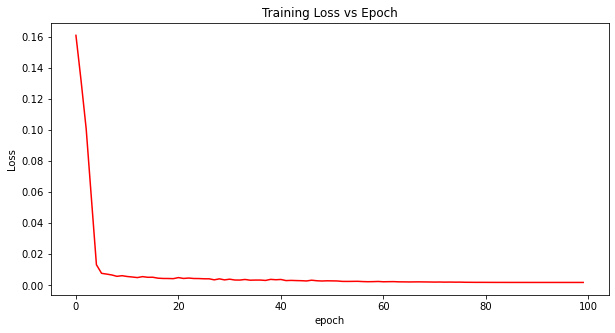

In [15]:
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color='red')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.show()

In [16]:
y_true = y_scaled.reshape(-1,540)
y_pred = y_pred.reshape(-1,540)

In [17]:
unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
R_squared = tf.subtract(1, tf.divide(unexplained_error, total_error))
print(f'r2 score of the model:{R_squared.numpy():.4f}')

r2 score of the model:0.9645


### Model Architecture Visualization

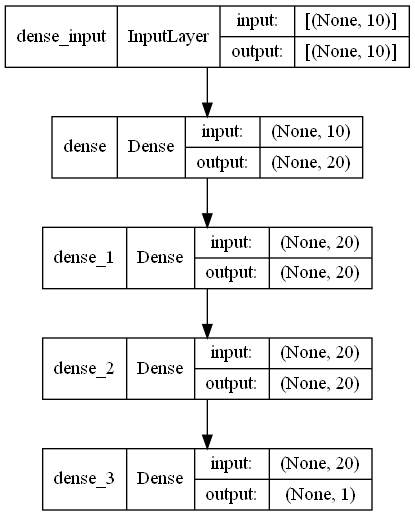

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model.reg, to_file='model.png',show_shapes=True)